# Apple Health Extractor

This code will parse your Apple Health export data, create multiple CSV and do some simple data checks and data analysis. 

Enjoy! 

--------

## Extract Data and Export to CSVs from Apple Health's Export.xml

* Command Line Tool to Process apple health's export.xml file 
* Create multiple CSV files for each data type. 
* Original Source: https://github.com/tdda/applehealthdata
* Based on the size of your Apple Health Data, this script may take several minutes to complete.

**NOTE: Currently there are a few minror errors based on additional data from Apple Health that require some updates.** 

## Setup and Usage NOTE

* Export your data from Apple Health App on your phone. 
* Unzip export.zip into this directory and rename to data. 
* Inside your directory there should be a directory and file here: /data/export.xml
* Run inside project or in the command line.

In [2]:
# %run -i 'apple-health-data-parser' 'export.xml' 
%run -i 'apple-health-data-parser' '/home/jovyan/work/экспорт.xml' 

Reading data from /home/jovyan/work/экспорт.xml . . . done
Unexpected node of type ExportDate.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node of type Correlation.
Unexpected node o

-----

# Apple Health Data Check and Data Analysis

In [2]:
import numpy as np
import pandas as pd
import glob
from datetime import datetime as dt
import dateutil.parser
import seaborn as sns
from matplotlib import pyplot

----

In [3]:
fat = pd.read_csv("/home/jovyan/work/data/DietaryFatTotal.csv", )
cholesterol = pd.read_csv("/home/jovyan/work/data/DietaryCholesterol.csv")
sodium = pd.read_csv("/home/jovyan/work/data/DietarySodium.csv")
carbohydrates = pd.read_csv("/home/jovyan/work/data/DietaryCarbohydrates.csv")
fiber = pd.read_csv("/home/jovyan/work/data/DietaryFiber.csv")
sugar = pd.read_csv("/home/jovyan/work/data/DietaryEnergyConsumed.csv")
protein = pd.read_csv("/home/jovyan/work/data/DietaryProtein.csv")
exercise = pd.read_csv("/home/jovyan/work/data/AppleExerciseTime.csv")
heart_rate_variability = pd.read_csv("/home/jovyan/work/data/HeartRateVariabilitySDNN.csv")
weight = pd.read_csv("/home/jovyan/work/data/BodyMass.csv")
basal_energy = pd.read_csv("/home/jovyan/work/data/BasalEnergyBurned.csv")
active_energy = pd.read_csv("/home/jovyan/work/data/ActiveEnergyBurned.csv")
body_fat_percent = pd.read_csv("/home/jovyan/work/data/BodyFatPercentage.csv")
body_mass_index = pd.read_csv("/home/jovyan/work/data/BodyMassIndex.csv")
lean_body_mass = pd.read_csv("/home/jovyan/work/data/LeanBodyMass.csv")
step_count = pd.read_csv('/home/jovyan/work/data/StepCount.csv')
v02max = pd.read_csv('/home/jovyan/work/data/VO2Max.csv')

In [4]:
activity_summary = pd.read_csv('/home/jovyan/work/data/ActivitySummary.csv')

In [5]:
activity_summary['ddate'] = activity_summary['dateComponents'].apply(lambda x: dt.strptime(x[:10], '%Y-%m-%d'))

You can change period here

In [7]:
calendar = pd.DataFrame({'ddate': pd.date_range(start='2021-01-01', end='2021-03-20')})

In [8]:
all_metrics = (
    fat,
    cholesterol,
    sodium,
    carbohydrates,
    fiber,
    sugar,
    protein,
    exercise,
    heart_rate_variability,
    weight,
    lean_body_mass,
    basal_energy,
    body_fat_percent,
    body_mass_index,
    active_energy,
    step_count,
    v02max,
)

In [9]:
for df in all_metrics:
    df['ddate'] = df['startDate'].apply(lambda x: dt.strptime(x[:10], '%Y-%m-%d'))

In [10]:
def format_dataframe(df, ):
    data_type = df.type[0]

    if (
        'Percent' not in data_type and
        data_type not in ['BodyMass', 'LeanBodyMass']
    ):
        return df.groupby(['ddate', 'unit', 'type'])[['value']].sum().reset_index()
    else:
        new_df = df.groupby(['ddate', 'unit', 'type'])[['value']].mean().reset_index()
        return new_df 


In [11]:
report = calendar

for df in all_metrics:
    df = format_dataframe(df)
    df['value'] = df[['value']].rolling(7).mean()
    report = pd.merge(report, df[['ddate', 'value']], how='left', on='ddate')
    report.rename(
        columns={
            'value': df['type'][0]
        },
        inplace=True,
    )

In [12]:
activity_summary = activity_summary.set_index(
    'ddate',
).rolling(7).mean().reset_index().dropna(axis=0)

In [13]:
report = pd.merge(report, activity_summary, how='left', left_on='ddate', right_on='ddate')

In [14]:
report.drop([
    'appleStandHoursGoal', 
    'activeEnergyBurnedGoal',
    'appleExerciseTimeGoal',
], axis=1, inplace=True)

## Pearson correlation heatmap

----

In [15]:
report.dropna(axis=0, inplace=True)

In [16]:
corr = report.corr()

<AxesSubplot:>

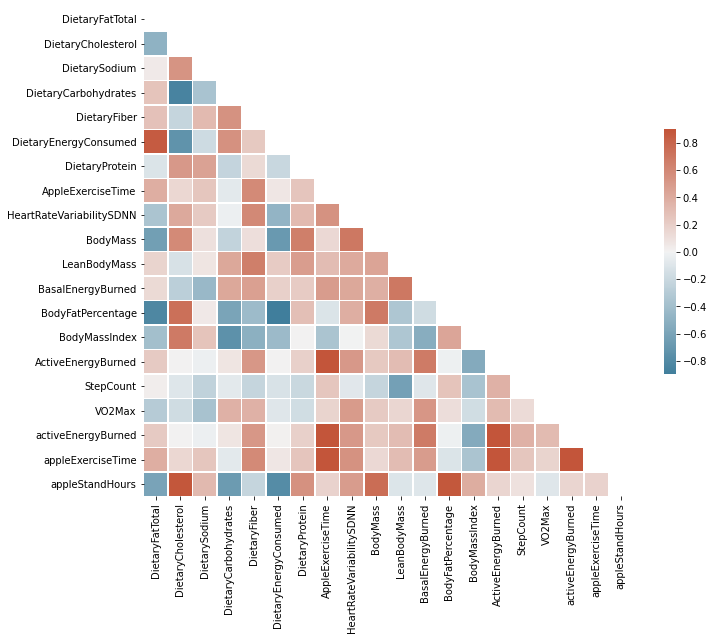

In [17]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = pyplot.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt=".1")

## Time charts

----

In [18]:
report.set_index('ddate', inplace=True)

<AxesSubplot:xlabel='ddate'>

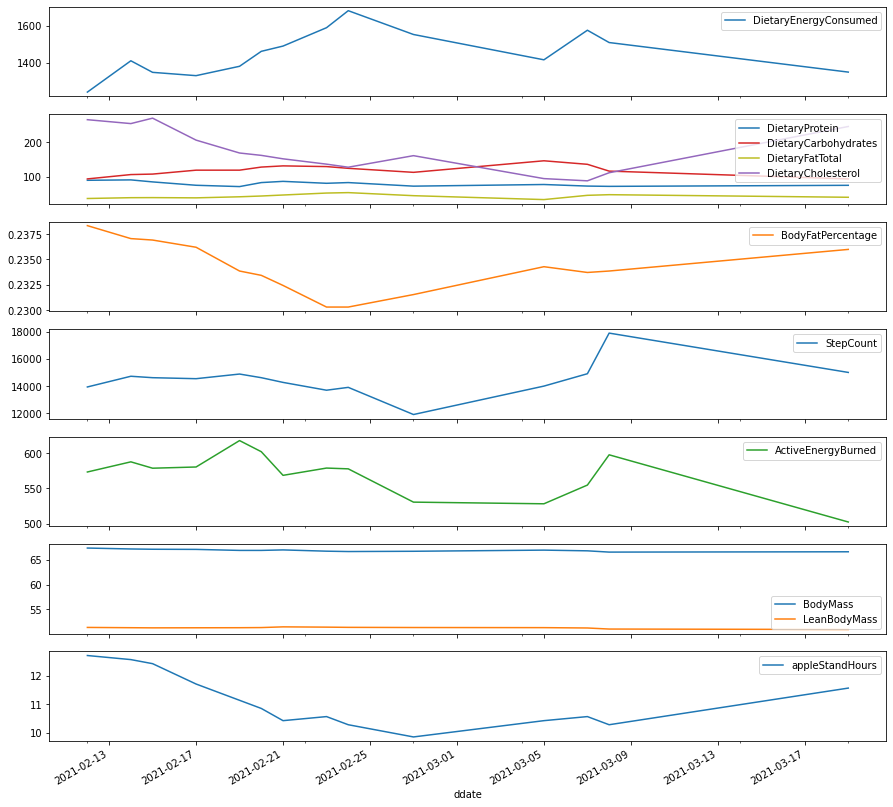

In [19]:
fig, axes = pyplot.subplots(nrows=7, ncols=1, sharex=True, )

fig.set_figheight(15)
fig.set_figwidth(15)

report[[
        'DietaryEnergyConsumed',
]].plot(ax=axes[0])

report[
    [
        'DietaryProtein',
        'DietaryCarbohydrates',
        'DietaryFatTotal',
        'DietaryCholesterol',        
    ]
].plot(ax=axes[1], color=['tab:blue', 'tab:red', 'tab:olive', 'tab:purple'])

report[
    [
        'BodyFatPercentage',
        
    ]
].plot(ax=axes[2], color=['tab:orange'])

report[
    [
        'BodyMass',
        'LeanBodyMass',
        
    ]
].plot(ax=axes[5])

report[
    [
        'ActiveEnergyBurned',
        
    ]
].plot(ax=axes[4], color=['tab:green'])

report[
    [
        'StepCount',
        
    ]
].plot(ax=axes[3])

report[
    [
        'appleStandHours',
        
    ]
].plot(ax=axes[6])